<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-1/blob/main/Code_Practice_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## < RNN 실습 >

- RNNCell / RNN

- 각 행별로 28번 인풋으로 들어감

- Many to one

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np

In [ ]:
## RNNCell (1개의 time step)

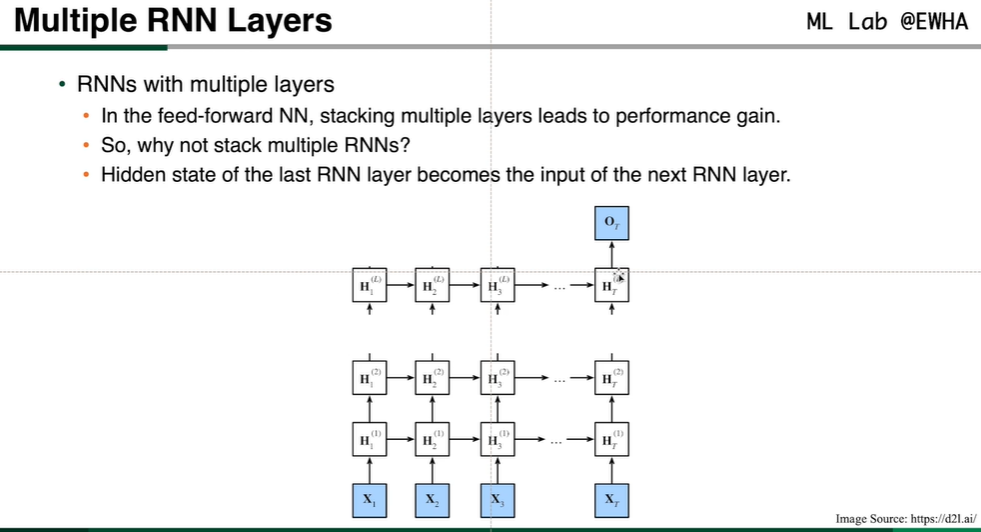

In [ ]:
path = './datasets/'

- 각 time step = 이미지의 한 행 (28개의 픽셀)

- 시퀀스 길이 = 28 (총 28행)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = MNIST(root=path, train=True, download=True, transform=transform)
test_data = MNIST(root=path, train=False, download=True, transform=transform)

batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# seq_len: row 수, input_size: column 수
_, seq_len, input_size = train_data[0][0].shape # 1, 28, 28
output_shape = len(train_data.classes) # 10

hidden_size = input_size*2 # 28*2 = 56 임의로 설정

model_name = 'rnn' # rnn, lstm, gru

device = torch
if torch.backends.mps.is_available():
    device = torch.device('mps:0')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class RNNClassifier(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.input_size = input_size # 28
        self.hidden_size = hidden_size # 56

        self.cell = nn.RNNCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, output_shape) # 마지막 hidden state -> 출력층으로 변환

    def forward(self, x):
        # x.shape = 100, 1, 28, 28 -> 100, 28, 28, x.squeeze() -> 28, 100, 28 = seq_len, batch_size, input_size
        x = x.reshape(-1, seq_len, self.input_size).permute((1,0,2)) # RNN은 시퀀스 형태로 받아야 하기 때문에
        hidden_state = torch.zeros(batch_size, self.hidden_size).to(device) # 초깃값 0으로 hidden state 설정

        for i in range(seq_len): # 시퀀스 길이만큼 반복하며 hidden state 갱신
            hidden_state = self.cell(x[i], hidden_state)
        out = self.fc(hidden_state) # 마지막 시점의 hidden state를 fully connected layer로 전달

        return out # 클래스 예측 결과 반환

class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size):
    super().__init__()

        self.input_size = input_size # 28
        self.hidden_size = hidden_size # 56

        self.cell = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, output_shape)

    def forward(self,x):
        x = x.reshape(-1, seq_len, self.input_size).permute((1,0,2))
        hidden_state = torch.zeros(batch_size,self.hidden_size).to(device)
        cell_state = torch.zeros(batch_size,self.hidden_size).to(device) # RNNCell과 차이점

        for i in range(seq_len):
          hidden_state, cell_state = self.cell(x[i], (hidden_state, cell_state)) # RNNCell과 차이점
        out = self.fc(hidden_state)

        return out

class GRUClassifier(nn.Module): # 구현 상으로 RNNCell과 완벽하게 동일

  def __init__(self, input_size, hidden_size):
        super().__init__()

        self.input_size = input_size # 28
        self.hidden_size = hidden_size # 56

        self.cell = nn.GRUCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, output_shape)

  def forward(self, x):
        x = x.reshape(-1, seq_len, self.input_size).permute((1,0,2))
        hidden_state = torch.zeros(batch_size,self.hidden_size).to(device)

        for i in range(seq_len):
            hidden_state = self.cell(x[i], hidden_state)
        out = self.fc(hidden_state)

        return out

if model_name == "rnn":
  classifier = RNNClassifier
elif model_name == "lstm":
  classifier = LSTMClassifier
elif model_name == "gru":
  classifier = GRUClassifier


In [ ]:
model = classifier(input_size, hidden_size).to(device)
loss = nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epoch = 100
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):

  ## train
  model.train()

  total_loss = 0
  count = 0

  for batch_idx, (x, y) in enumerate(train_loader):

    x, y = x.to(device), y.to(device)

    y_est = model.forward(x)
    cost = loss(y_est, y)

    total_loss += cost.item() * len(x)

    optimazer.zero_grad()
    cost.backward()
    optimizer.step()

    pred = torch.argmax(y_est, dim=-1)
    count += (pred == y).sum().item()

  acc = count/len(train_data)
  ave_loss = total_loss/len(train_data)

  train_loss_list.append(ave_loss)

  if i % 1 == 0:
      print("\nEpoch %d Train: %.3f / %.3f"%(i,ave_loss,acc))

  ## test
  model.eval()

  total_loss = 0
  count = 0

  with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):

        x, y = x.to(device), y.to(device)

        y_est = model.forward(x)
        cost = loss(y_est, y)

        total_loss += cost.item() * len(x)

        pred = torch.argmax(y_est, dim=-1)
        count += (pred == y).sum().item()

  acc = count/len(test_data)
  ave_loss = total_loss/len(test_data)

  test_loss_list.append(ave_loss)

  if i % 1 == 0:
      print("Epoch %d Test: %.3f / %.3f"%(i,ave_loss,acc))


In [ ]:
## RNN
# CIFAR10 데이터셋

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np

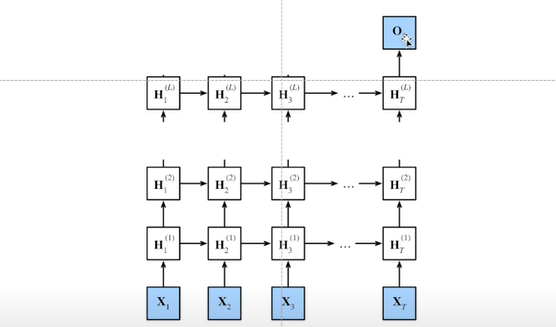

In [ ]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

train_data = CIFAR10(root=path, train=True, transform=transform, download=True)
test_data = CIFAR10(root=path, train=False, transform=transform, download=True)

batch_size = 100

trainLoader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

num_channel, seq_len, input_size = train_data[0][0].shape # (3, 32, 32)
output_shape = len(train_data.classes) # 10

hidden_size = input_size * 2     # 은닉층 크기 = 64
num_layers = 3                   # RNN 계층 수
batch_first = True               # 입력 형태 (B, S, F)
bidirectional = True             # 양방향 RNN 사용 여부
model_name = 'gru'               # 사용할 모델 (rnn/lstm/gru)

class RNNClassifier(nn.Module):
  def __init__(self, num_channel, input_size, hidden_size, num_layers=1, batch_first=True, bidirectional=False):
    super().__init__()

    self.num_channel = num_channel
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional: # 양방항이면 cell이 2배가 됨
        self.direction = 2
    else:
        self.direction = 1

    self.seq = nn.RNN(input_size=self.input_size * self.num_channel, # 32*3 = 9
                      hidden_size=self.hidden_size, # 64
                      num_layers=self.num_layers, # 3
                      batch_first=self.batch_first,
                      bidirectional=self.bidirectional)
    self.fc = nn.Linear(self.hidden_size*self.direction, output_shape) # (64, 10)

 def forward(self, x):
  # x.shape = 100, 3, 32, 32 = batch_size, num_channel, seq_len, input_dim
  # -> ...
  # -> 100, 32, 3*32 = batch_size, seq_len, num_channel*input_dim
  x = x.permute((0,2,3,1)).reshape(-1, seq_len, self.input_size*self.num_channel)
  h0 = torch.zeros(self.direction * self.num_layers, batch_size, self.hidden_size) # 상수
  out, hidden = self.seq(x, h0.detach().to(device)) # h0.detach(): gradient 연산 제외
  # output: 마지막 RNN 레이어로부터 나온 hidden들 /  hidden: 마지막 time step에서부터 나온 hidden들
  out = out[:, -1, :].squeeze() # (B, seq_len, 1, 64) # 라스트 time step에 대해서
  out = self.fc(out)

  return out


In [ ]:
# 앞에 코드와 정확하게 동일
model = classifier(input_size, hidden_size).to(device)
loss = nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epoch = 100
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):

  ## train
  model.train()

  total_loss = 0
  count = 0

  for batch_idx, (x, y) in enumerate(train_loader):

    x, y = x.to(device), y.to(device)

    y_est = model.forward(x)
    cost = loss(y_est, y)

    total_loss += cost.item() * len(x)

    optimazer.zero_grad()
    cost.backward()
    optimizer.step()

    pred = torch.argmax(y_est, dim=-1)
    count += (pred == y).sum().item()

  acc = count/len(train_data)
  ave_loss = total_loss/len(train_data)

  train_loss_list.append(ave_loss)

  if i % 1 == 0:
      print("\nEpoch %d Train: %.3f / %.3f"%(i,ave_loss,acc))

  ## test
  model.eval()

  total_loss = 0
  count = 0

  with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):

        x, y = x.to(device), y.to(device)

        y_est = model.forward(x)
        cost = loss(y_est, y)

        total_loss += cost.item() * len(x)

        pred = torch.argmax(y_est, dim=-1)
        count += (pred == y).sum().item()

  acc = count/len(test_data)
  ave_loss = total_loss/len(test_data)

  test_loss_list.append(ave_loss)

  if i % 1 == 0:
      print("Epoch %d Test: %.3f / %.3f"%(i,ave_loss,acc))

In [ ]:
# bidirectional 옵션을 준 경우 위의 코드가 잘못된 코드가
# out = out[:,-1,:].squuze()부분 문제가 됨
# 왜?

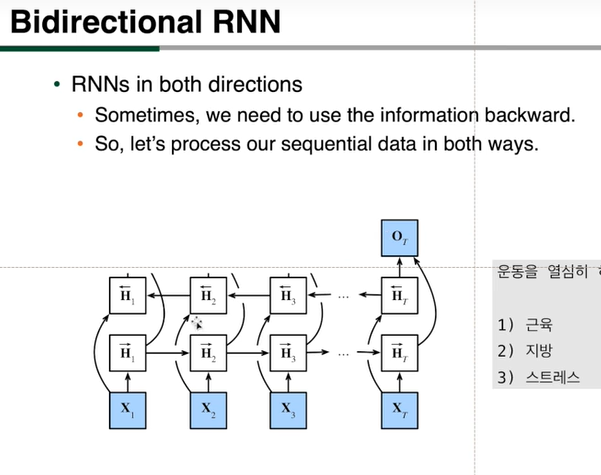

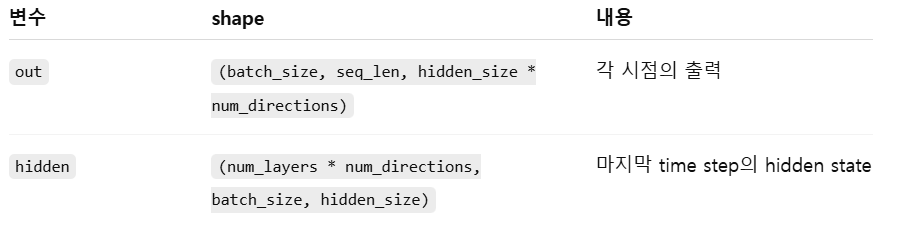

- RNN은 시퀀스를 정방향(왼→오)과 역방향(오→왼) 두 방향으로 학습함

- 그래서 out[:, -1, :]은 “정방향의 마지막 step + 역방향의 마지막 step”이 섞인 텐서가 아니라, 두 방향의 hidden이 concat된 텐서임

- seq_len 기준 마지막 step은 정방향의 마지막 step만 의미하므로 역방향의 “첫 번째 step 결과”는 누락됨


In [ ]:
num_directions = 1
out[:, -1, :]  # → 마지막 시점의 hidden만 가져오면 됨

# 수정 버전
def forward(self, x):
    x = x.permute((0,2,3,1)).reshape(-1, seq_len, self.input_size * self.num_channel)
    B = x.size(0)

    h0 = torch.zeros(self.direction * self.num_layers, B, self.hidden_size).to(device)
    out, hidden = self.seq(x, h0)

    if self.bidirectional:
        h_forward = hidden[-2, :, :] # 정방향 마지막 layer의 hidden
        h_backward = hidden[-1, :, :] # 역방향 마지막 layer의 hidden
        out = torch.cat((h_forward, h_backward), dim=1)
    else:
        out = hidden[-1, :, :]

    out = self.fc(out)
    return out

In [ ]:
# LSTM 수정 버전


In [ ]:
# cell state 부분만 추가
class LSTMClassifier(nn.Module):
  def __init__(self, num_channel, input_size, hidden_size, num_layers=1, batch_first=True, bidirectional=False):
    super().__init__()

    self.num_channel = num_channel
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional: # 양방항이면 cell이 2배가 됨
        self.direction = 2
    else:
        self.direction = 1

    self.seq = nn.RNN(input_size=self.input_size * self.num_channel, # 32*3 = 9
                      hidden_size=self.hidden_size, # 64
                      num_layers=self.num_layers, # 3
                      batch_first=self.batch_first,
                      bidirectional=self.bidirectional)
    self.fc = nn.Linear(self.hidden_size*self.direction, output_shape) # (64, 10)

 def forward(self, x):
  # x.shape = 100, 3, 32, 32 = batch_size, num_channel, seq_len, input_dim
  # -> ...
  # -> 100, 32, 3*32 = batch_size, seq_len, num_channel*input_dim
  x = x.permute((0,2,3,1)).reshape(-1, seq_len, self.input_size*self.num_channel)
  h0 = torch.zeros(self.direction * self.num_layers, batch_size, self.hidden_size) # 상수
  c0 = torch.zeros(self.direction * self.num_layers, batch_size, self.hidden_size)
  out,(hidden, cell) = self.seq(x, (h0.detach().to(device), c0.detach().to(device))) # h0.detach(): gradient 연산 제외
  # output: 마지막 RNN 레이어로부터 나온 hidden들 /  hidden: 마지막 time step에서부터 나온 hidden
  out = out[:, -1, :].squeeze() # (B, seq_len, 1, 64) # 라스트 time step에 대해서
  out = self.fc(out)

  return out


In [ ]:
# GRU는 RNN과 완전 동일한 코드
class GRUClassifier(nn.Module):
  def __init__(self, num_channel, input_size, hidden_size, num_layers=1, batch_first=True, bidirectional=False):
    super().__init__()

    self.num_channel = num_channel
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional: # 양방항이면 cell이 2배가 됨
        self.direction = 2
    else:
        self.direction = 1

    self.seq = nn.RNN(input_size=self.input_size * self.num_channel, # 32*3 = 9
                      hidden_size=self.hidden_size, # 64
                      num_layers=self.num_layers, # 3
                      batch_first=self.batch_first,
                      bidirectional=self.bidirectional)
    self.fc = nn.Linear(self.hidden_size*self.direction, output_shape) # (64, 10)

 def forward(self, x):
  # x.shape = 100, 3, 32, 32 = batch_size, num_channel, seq_len, input_dim
  # -> ...
  # -> 100, 32, 3*32 = batch_size, seq_len, num_channel*input_dim
  x = x.permute((0,2,3,1)).reshape(-1, seq_len, self.input_size*self.num_channel)
  h0 = torch.zeros(self.direction * self.num_layers, batch_size, self.hidden_size) # 상수
  out, hidden = self.seq(x, h0.detach().to(device)) # h0.detach(): gradient 연산 제외
  # output: 마지막 RNN 레이어로부터 나온 hidden들 /  hidden: 마지막 time step에서부터 나온 hidden
  out = out[:, -1, :].squeeze() # (B, seq_len, 1, 64) # 라스트 time step에 대해서
  out = self.fc(out)

  return out
